In [1]:
!wget -O Andrey.zip https://www.dropbox.com/scl/fo/y61ym98x1ier382clv1zj/h?rlkey=0fz9i1bzonbbkj9gwi9jw4h0p&dl=0

--2023-11-26 14:39:41--  https://www.dropbox.com/scl/fo/y61ym98x1ier382clv1zj/h?rlkey=0fz9i1bzonbbkj9gwi9jw4h0p
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc31f80ecc0316e360bb49be8d50.dl.dropboxusercontent.com/zip_download_get/BrrDCuQ_MMKwG_DcCVLhEBbBYeHdWejDIywYEV9dr1jw43E8sZzvY6-2hjmdhAhJTliRsT9ycUbCBDYDr7PGy55HtdhXf06JfgJLPyxxoQAfcw# [following]
--2023-11-26 14:39:43--  https://uc31f80ecc0316e360bb49be8d50.dl.dropboxusercontent.com/zip_download_get/BrrDCuQ_MMKwG_DcCVLhEBbBYeHdWejDIywYEV9dr1jw43E8sZzvY6-2hjmdhAhJTliRsT9ycUbCBDYDr7PGy55HtdhXf06JfgJLPyxxoQAfcw
Resolving uc31f80ecc0316e360bb49be8d50.dl.dropboxusercontent.com (uc31f80ecc0316e360bb49be8d50.dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6021:15::a27d:410f
Connecting to uc31f80ecc0316e360bb49be8d50.dl.dropboxusercontent.com 

In [3]:
#!unzip Andrey.zip

In [ ]:
#!g2.1


In [1]:
#!g2.1
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#!g2.1
from albumentations import (HorizontalFlip, Normalize, Resize, Compose, RandomCrop)
from albumentations.pytorch import ToTensorV2

In [3]:
#!g2.1
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):
        images_paths.append(os.path.join(path, filename))

    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        im_name = self.images[idx]
        mask_name = self.masks[idx]

        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }

        augmented = self.transform(image=image, mask=mask)
        sample['image'] = augmented['image'].float()
        sample['mask'] = augmented['mask'].float()

        #sample['image'] = transforms.RandomHorizontalFlip(sample['image'], flip_p).float()
        #sample['mask'] = transforms.RandomHorizontalFlip(sample['mask'], flip_p).float()

        return sample['image'], sample['mask'][None, :, :]

In [4]:
#!g2.1
class RoadDatasetVal(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        im_name = self.images[idx]
        mask_name = self.masks[idx]

        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }

        augmented = self.transform(image=image, mask=mask)
        sample['image'] = augmented['image'].float()
        sample['mask'] = augmented['mask'].float()

        return sample['image'], sample['mask'][None, :, :]

In [5]:
#!g2.1
X_train = get_paths("train/images")
y_train = get_paths("train/gt")

transform = Compose([Resize(600, 600),
                     HorizontalFlip(p=0.5),
                     RandomCrop(512, 512),
                     ToTensorV2()])

In [6]:
#!g2.1
X_test = get_paths("test/images")
y_test = get_paths("test/gt")

transform_val = Compose([Resize(512, 512),
                     ToTensorV2()])

In [7]:
#!g2.1
train_dataset = RoadDataset(X_train, y_train, transform)

In [8]:
#!g2.1
test_dataset = RoadDataset(X_test, y_test, transform_val)

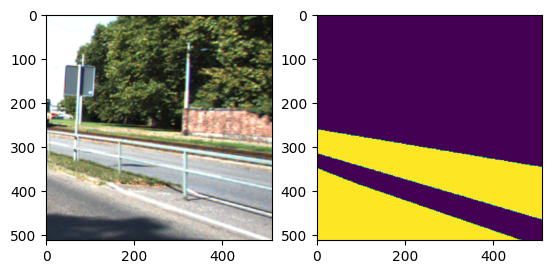

In [9]:
#!g2.1
image, mask = train_dataset[13]

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask[0])

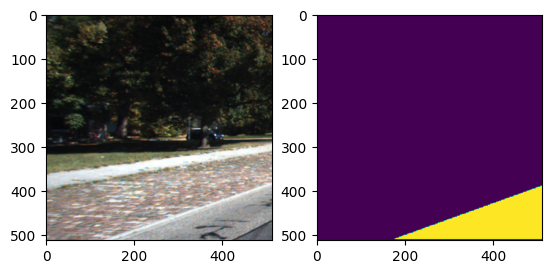

In [10]:
#!g2.1
image, mask = test_dataset[13]

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask[0])

In [11]:
#!g2.1
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


In [25]:
#!g2.1
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection_1 = np.logical_and(prediction[i] > 0.5, ground_truth[i] > 0).astype(np.float32).sum()
        intersection += intersection_1

        union1 = np.logical_or(prediction[i] > 0.5, ground_truth[i] > 0).astype(np.float32).sum()
        union += union1

        #print(intersection_1, union1)
    return intersection / union

In [13]:
#!g2.1
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]

In [14]:
%pip install segmentation-models-pytorch

In [15]:
#!g2.1
import segmentation_models_pytorch as smp

In [16]:
#!g2.1
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1,
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1,
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [17]:
#!g2.1
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [18]:
#!g2.1
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
#!g2.1
TRAINING = True

EPOCHS = 15

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = smp.losses.DiceLoss(mode='binary')
#metrics = [smp.metrics.IoU(threshold=0.5)]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0005),
])

In [20]:
#!g2.1
DEVICE

device(type='cuda')

In [21]:
#!g2.1
from tqdm.notebook import tqdm

In [22]:
#!g2.1
model = model.to(DEVICE)

In [24]:
#!g2.1
loss_epochs = []
iou_epochs = []
iou_test_epochs = []

for i in range(EPOCHS):
    loss_s = []
    iou_s = []
    iou_s_test = []

    for X, y in tqdm(train_loader):
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(X)
        loss_out = loss(logits, y)
        loss_s.append(loss_out.cpu().data.numpy())
        np_logits = logits.cpu().data.numpy()
        np_y = y.cpu().data.numpy()
        iou_s.append(calc_iou(np_logits[:, 0, :, :], np_y[:, 0, :, :]))

        optimizer.zero_grad()
        loss_out.backward()
        optimizer.step()
    for X, y in tqdm(test_loader):
        with torch.no_grad():
            X = X.to(DEVICE)
            y = y.to(DEVICE)

            logits = model(X)

            np_logits = logits.cpu().data.numpy()
            np_y = y.cpu().data.numpy()

            iou_s_test.append(calc_iou(np_logits[:, 0, :, :], np_y[:, 0, :, :]))

    mean_loss = np.array(loss_s).mean()
    mean_iou = np.array(iou_s).mean()
    mean_iou_test = np.array(iou_s_test).mean()

    loss_epochs.append(mean_loss)
    iou_epochs.append(mean_iou)
    iou_test_epochs.append(mean_iou_test)

    print(f"Loss train : {mean_loss} on epoch {i}")
    print(f"IOU train : {mean_iou} on epoch {i}")
    print(f"IOU test : {mean_iou_test} on epoch {i}")


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6474669575691223 on epoch 0
IOU train : 0.6430908832302795 on epoch 0
IOU test : 0.65181095767607 on epoch 0


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.641922116279602 on epoch 1
IOU train : 0.6511588792496406 on epoch 1
IOU test : 0.6546456013895251 on epoch 1


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6404756903648376 on epoch 2
IOU train : 0.6518693788728506 on epoch 2
IOU test : 0.6780357956992196 on epoch 2


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6416747570037842 on epoch 3
IOU train : 0.6758403328064075 on epoch 3
IOU test : 0.6641712154294559 on epoch 3


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6372815370559692 on epoch 4
IOU train : 0.7160228328189887 on epoch 4
IOU test : 0.6850313687975891 on epoch 4


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6324270963668823 on epoch 5
IOU train : 0.7312319697097278 on epoch 5
IOU test : 0.7084210985398653 on epoch 5


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6347967386245728 on epoch 6
IOU train : 0.708130486699701 on epoch 6
IOU test : 0.7038468890562647 on epoch 6


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6329460740089417 on epoch 7
IOU train : 0.7200771610417175 on epoch 7
IOU test : 0.720259573190596 on epoch 7


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6325594782829285 on epoch 8
IOU train : 0.7416172378844971 on epoch 8
IOU test : 0.7110307070648888 on epoch 8


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6341028213500977 on epoch 9
IOU train : 0.7480284842782132 on epoch 9
IOU test : 0.7162297078350243 on epoch 9


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6304489374160767 on epoch 10
IOU train : 0.7615638162987733 on epoch 10
IOU test : 0.7469470893300425 on epoch 10


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6315947771072388 on epoch 11
IOU train : 0.7754420925654595 on epoch 11
IOU test : 0.7475677658167176 on epoch 11


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6317898035049438 on epoch 12
IOU train : 0.7319974661214884 on epoch 12
IOU test : 0.6926476428686877 on epoch 12


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6354799270629883 on epoch 13
IOU train : 0.7346968383871543 on epoch 13
IOU test : 0.756614517537436 on epoch 13


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Loss train : 0.6352118849754333 on epoch 14
IOU train : 0.7439908349401975 on epoch 14
IOU test : 0.7138336934508855 on epoch 14


In [27]:
batch = next(iter(train_loader))
images, masks = batch

In [28]:
images[3].unsqueeze(0).to(DEVICE).cpu().data.numpy()[0][0].shape

(512, 512)

In [30]:
sz = 15

In [38]:
def show_results(idx):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  axes[0].imshow(images[idx][0], cmap='bone')
  axes[0].set_title('Input Image')
  axes[0].axis('off')

  axes[1].imshow(masks[idx][0], alpha=0.3)
  axes[1].set_title('True Mask')
  axes[1].axis('off')

  pred_mask = model.predict(images[idx].unsqueeze(0).to(DEVICE))[0].cpu().data.numpy()[0]
  axes[2].imshow(pred_mask, cmap='bone')
  axes[2].set_title('Predicted Mask')
  axes[2].axis('off')

  plt.tight_layout()
  plt.show()

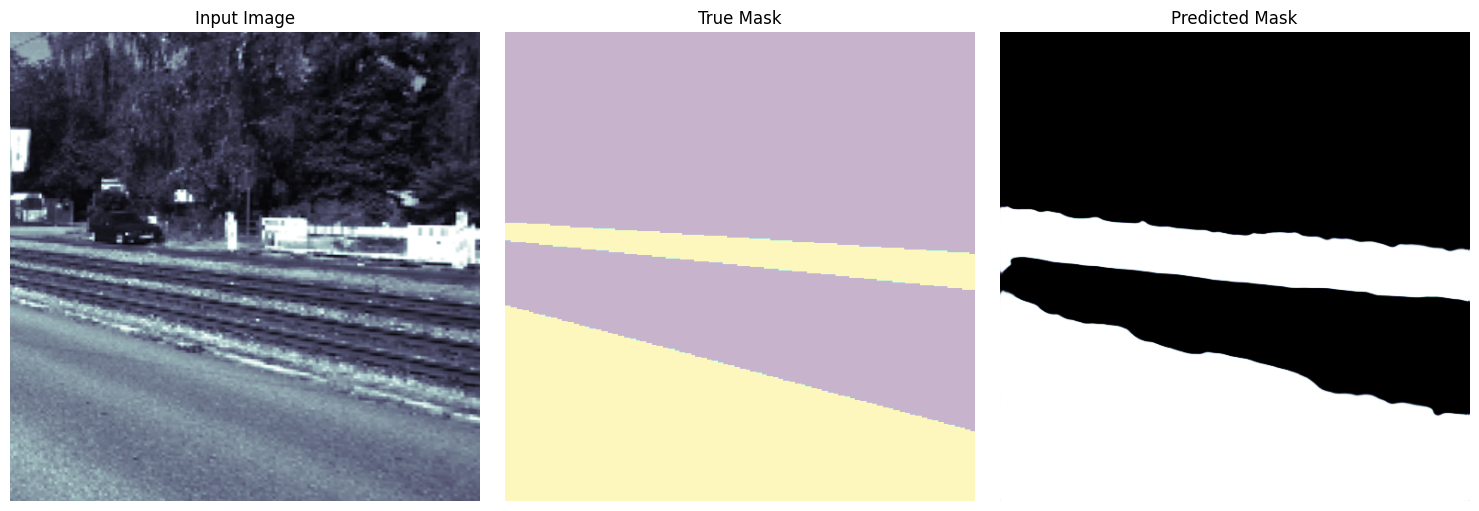

In [39]:
show_results(2)

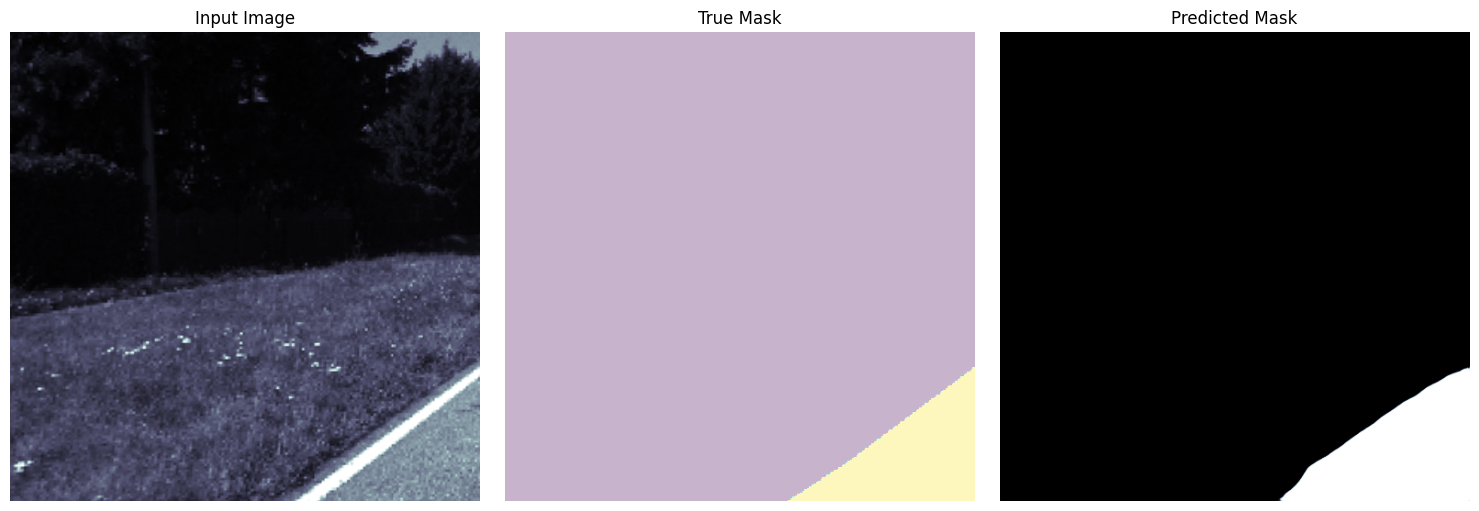

In [40]:
show_results(3)

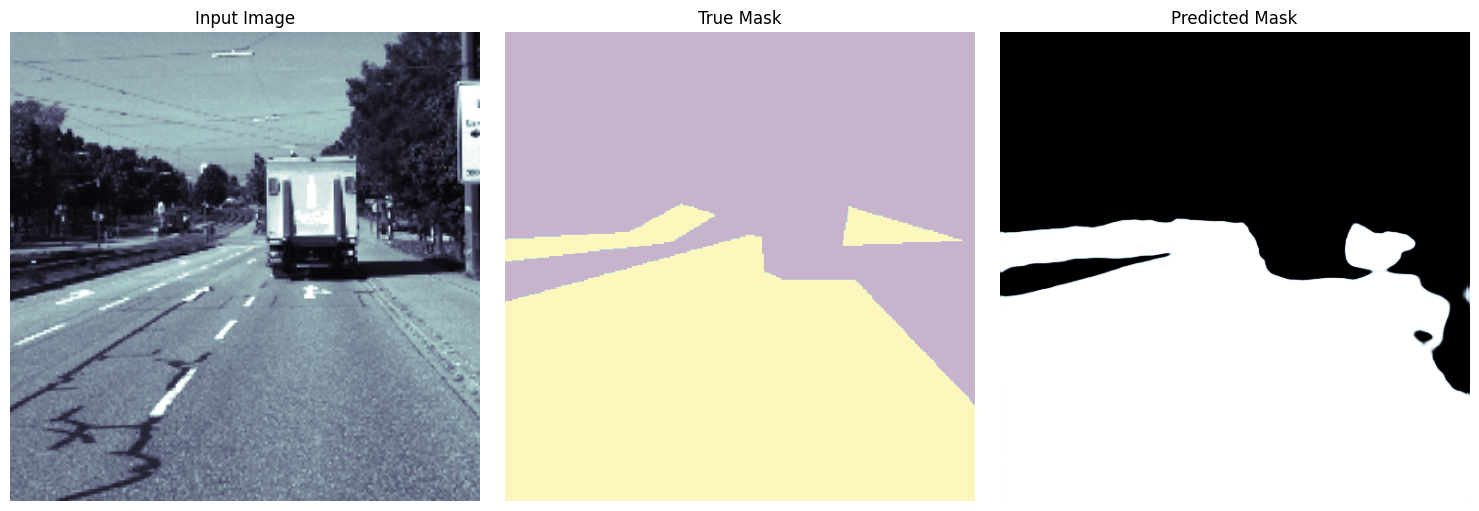

In [43]:
show_results(6)